In [7]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
# зафиксируем RANDOM SEED
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов:
!pip freeze > requirements.txt

In [4]:
# функции

def PlotConfusionMatrix(y_test, pred, y_test_0, y_test_1):
    """Функция для построения confusion matrix"""
    cfn_matrix = confusion_matrix(y_test, pred)
    cfn_norm_matrix = np.array(
    [[1.0 / y_test_0, 1.0/y_test_0], [1.0/y_test_1, 1.0/y_test_1]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix
    fig = plt.figure(figsize=(6,4))
    sns.heatmap(norm_cfn_matrix, cmap='coolwarm_r',
            linewidths=0.5, annot=True)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    print('---Classification Report---')
    print(classification_report(y_test, pred, labels=np.unique(pred)))

def AUC_ROC(model):
    """Функция для построения ROC-кривой и расчета AUC"""
    # посчитаем fpr, tpr для всех thresholds
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [5]:
#откроем файлы с данными
train = pd.read_csv('train1.csv')
test = pd.read_csv('test1.csv')
sample_prediction = pd.read_csv('sample_prediction1.csv')

In [6]:
# объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем трейн
test['sample'] = 0 # помечаем тест
test['Y'] = 3 # заполняем Y
data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [7]:
# посмотрим на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279886 entries, 0 to 279885
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   VASK0       279886 non-null  int64
 1   VASK1       279886 non-null  int64
 2   VASK2       279886 non-null  int64
 3   VASK3       279886 non-null  int64
 4   VASK4       279886 non-null  int64
 5   VBID0       279886 non-null  int64
 6   VBID1       279886 non-null  int64
 7   VBID2       279886 non-null  int64
 8   VBID3       279886 non-null  int64
 9   VBID4       279886 non-null  int64
 10  VASK0_PREV  279886 non-null  int64
 11  VASK1_PREV  279886 non-null  int64
 12  VASK2_PREV  279886 non-null  int64
 13  VASK3_PREV  279886 non-null  int64
 14  VASK4_PREV  279886 non-null  int64
 15  VBID0_PREV  279886 non-null  int64
 16  VBID1_PREV  279886 non-null  int64
 17  VBID2_PREV  279886 non-null  int64
 18  VBID3_PREV  279886 non-null  int64
 19  VBID4_PREV  279886 non-null  int64
 20  samp

#### Выводы: Датасет чистый, все значения int, пустых ячеек нет

In [8]:
data.columns

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'sample', 'Y'],
      dtype='object')

In [9]:
# посмотрим на значения целевой переменной
data['Y'].value_counts(normalize=True)

0    0.659826
3    0.333336
1    0.006838
Name: Y, dtype: float64

#### Выводы: Данные сильно несбалансированы, положительные исходы составляют всего 1% от выборки

## 1. Feature Engineering

In [10]:
# добавим в датасет спреды
spread_columns = []
for i in range(0,5):
    data['SPREAD'+str(i)] = data['VASK'+str(i)]-data['VBID'+str(i)]
    spread_columns.append('SPREAD'+str(i))

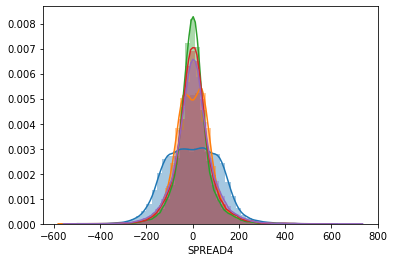

In [11]:
# визуализируем
for column in spread_columns:
    sns.distplot(data[column])
data = data.drop(spread_columns, axis=1)

#### Визуально видно, что данные распределены нормально, но потребуется стандартизировать значения

In [12]:
data.columns

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'sample', 'Y'],
      dtype='object')

In [13]:
# добавим в дата-сет признак MID
data['SPREAD0'] = (data['VASK0']-data['VBID0'])/(data['VASK0_PREV']-data['VBID0_PREV'])
data['SPREAD1'] = (data['VASK1']-data['VBID1'])/(data['VASK1_PREV']-data['VBID1_PREV'])

    
    #data['MID_PREV'+str(i)] = (data['VASK'+str(i)+'_PREV']-data['VBID'+str(i)+'_PREV'])/2
    #data['MID'+str(i)] = data['MID'+str(i)].replace([np.inf, -np.inf], 0).all()
    #data['MID_PREV'+str(i)] = data['MID_PREV'+str(i)].replace([np.inf, -np.inf], 0).all()

    #for i in range(0, 5):
    #data['MID_'+str(i)] = (data['MID'+str(i)]/ data['MID_PREV'+str(i)]+1)

In [14]:
# посчитаем volume imbalance
data['BID_PREV'] = np.log((data['VBID0'] + data['VBID1'] + data['VBID2'] +data['VBID3'] + data['VBID4'])/(data['VBID0_PREV'] + data['VBID1_PREV'] + data['VBID2_PREV'] +data['VBID3_PREV'] + data['VBID4_PREV']))
data['ASK_PREV'] = np.log((data['VASK0'] + data['VASK1'] + data['VASK2'] +data['VASK3'] + data['VASK4'])/(data['VASK0_PREV'] + data['VASK1_PREV'] + data['VASK2_PREV'] +data['VASK3_PREV'] + data['VASK4_PREV']))

In [15]:
# averge_ask
#data['AVG_ASK'] = (data['VASK0'] + data['VASK1'] + data['VASK2'] +data['VASK3'] + data['VASK4'])/5

In [16]:
# averge_bid
#data['AVG_BID'] = (data['VBID0'] + data['VBID1'] + data['VBID2'] +data['VBID3'] + data['VBID4'])/5

In [17]:
# посчитаем изменения объемов спроса
for i in range(1, 5):
    data['ASK_CHANGE'+str(i)] = np.log(data['VASK'+str(i)]/(data['VASK'+str(i-1)]))
    data['ASK_CH_0_'+str(i)] = np.log(data['VASK'+str(i)]/(data['VASK'+str(0)]))
    

In [18]:
# посчитаем изменения объемов предложения
for i in range(1, 5):
    data['BID_CHANGE'+str(i)] = (data['VBID'+str(i)]/(data['VBID'+str(i-1)]))
    data['BID_CH_0'+str(i)] = (data['VBID'+str(i)]/(data['VBID'+str(0)]))
    

In [19]:
# посчитаем соотношение
#for i in range(0, 5):
    #data['BID/ASK'+str(i)] = np.log(data['VBID'+str(i)]/(data['VASK'+str(i)]))

In [20]:
# логарифмируем VASK и VBID
#for i in range(0, 5):
    #data['VASK'+str(i)] = np.log(data['VASK'+str(i)])
    #data['VBID'+str(i)] = np.log(data['VBID'+str(i)])

In [21]:
data.columns

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'sample', 'Y', 'SPREAD0', 'SPREAD1',
       'BID_PREV', 'ASK_PREV', 'ASK_CHANGE1', 'ASK_CH_0_1', 'ASK_CHANGE2',
       'ASK_CH_0_2', 'ASK_CHANGE3', 'ASK_CH_0_3', 'ASK_CHANGE4', 'ASK_CH_0_4',
       'BID_CHANGE1', 'BID_CH_01', 'BID_CHANGE2', 'BID_CH_02', 'BID_CHANGE3',
       'BID_CH_03', 'BID_CHANGE4', 'BID_CH_04'],
      dtype='object')

In [22]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)
data = data.fillna(0)

In [23]:
#data = data.drop(['VASK2', 'VASK3', 'VASK4', 'VBID2', 'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
                  #'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV', 'VBID3_PREV', 'VBID4_PREV', 'BID_PREV_CHANGE3', 'BID_PREV_CHANGE1', 'BID_PREV_CHANGE4', 'ASK_CHANGE2', 'ASK_PREV_CHANGE2', 'BID_CHANGE4', 'ASK_CHANGE4',
                  #'BID_PREV_CHANGE2', 'ASK_PREV_CHANGE1', 'ASK_PREV_CHANGE4', 'BID_CHANGE3', 'ASK_CHANGE3', 'ASK_PREV_CHANGE3', 'BID_CHANGE2'], axis=1)

In [24]:

#data = data[['VASK0','VBID0','SPREAD0','SPREAD1','BID_CHANGE1','BID_CH_01','BID_CH_02','ASK_CH_0_1','ASK_CH_0_2','ASK_CHANGE1','sample', 'Y']]



In [25]:
data = data[['VASK0','VBID0','SPREAD0','BID_CHANGE1','BID_CH_02','ASK_CH_0_2','ASK_CHANGE1','sample', 'Y']]

In [26]:
# удалим признаки, которые не оказывают существенного влияния на качество модели, но имеют сильную корреляцию с признаками,
# которые мы сгенерили на их основе
#data = data[['VASK0', 'VBID0', 'LOGBID1', 'LOGASK1', 'LOGBID2', 'BID/ASK0', 'LOGBID3', 'LOGASK2', 'LOGBID4', 'BID/ASK2', 'LOGASK4', 'LOGBID3',
             #'BID/ASK1', 'VOL_IMB', 'AVG_ASK', 'AVG_BID','sample', 'Y']]

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279886 entries, 0 to 279885
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   VASK0        279886 non-null  int64  
 1   VBID0        279886 non-null  int64  
 2   SPREAD0      279886 non-null  float64
 3   BID_CHANGE1  279886 non-null  float64
 4   BID_CH_02    279886 non-null  float64
 5   ASK_CH_0_2   279886 non-null  float64
 6   ASK_CHANGE1  279886 non-null  float64
 7   sample       279886 non-null  int64  
 8   Y            279886 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 19.2 MB


## 2. Baseline

In [28]:
# в качестве baseline построим plain vanilla модель логистической регрессии на имеющихся features
# предпроцессинг
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop(['Y'], axis=1)
# выделяем целевую переменную
y = train_data['Y'].values
X = train_data.drop(['Y'], axis=1)

In [29]:
# делим трейн на обучающую и тестовую выборку
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

In [30]:
# посчитаем кол-во 0 и 1 на тесте
y_test_0 = np.sum(y_test==0)
y_test_1 = np.sum(y_test==1)

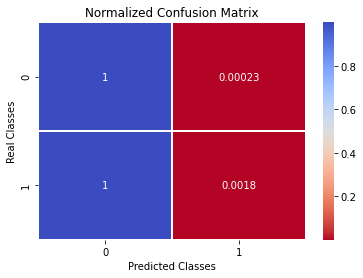

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55412
           1       0.07      0.00      0.00       565

    accuracy                           0.99     55977
   macro avg       0.53      0.50      0.50     55977
weighted avg       0.98      0.99      0.98     55977



In [31]:
# обучаем модель
lr_model = LogisticRegression(max_iter=1500, random_state=RANDOM_SEED)
lr_model.fit(x_train,y_train)
# предсказываем значения целевой переменной
pred = lr_model.predict(x_test)
# построим Confusion matrix
PlotConfusionMatrix(y_test,pred,y_test_0,y_test_1)

#### Выводы: для несбалансированных данных ожидаемо plain vanilla модель хорошо предсказывает отрицательные исходы (f1-score = 0.99) и очень плохо положительные, что дает взвешенный результат 0.50, что аналогично random choice

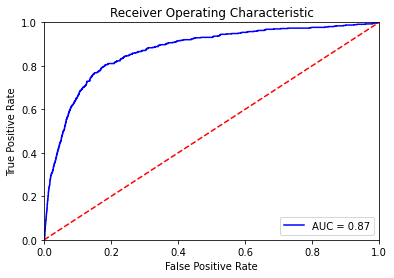

In [32]:
# построим ROC-кривую и посчитаем AUC
AUC_ROC(lr_model)

#### AUC базовой модели составляет 0.63 - попробуем его улучшить

## 3. Логистическая регрессия

In [33]:
# стандартизируем данные, используя Standard scaler
#st_scaler = RobustScaler()
#x_train = st_scaler.fit_transform(x_train)
#x_test = st_scaler.transform(x_test)

In [34]:
# попробуем решить проблему несбалансированных данных при помощи oversamling
# применим SMOTE, который сгенерит доп. положительные исходы на трейне
oversample = SMOTE()
x_train_smote, y_train_smote = oversample.fit_resample(x_train, y_train)

In [35]:
import lightgbm as lgb
lgb_train = lgb.Dataset(x_train_smote, y_train_smote)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [36]:
#X.columns[[0,1,10,2,13,18,14,4,17,20,9,15,19]]

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'nthread': -1,
    'feature_fraction': 0.4,
    'num_leaves': 50,
    'verbose': 0
}

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

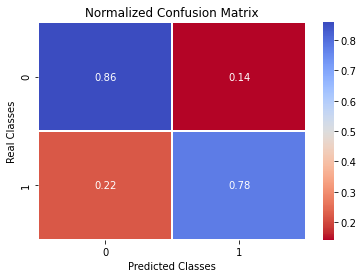

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     55412
           1       0.05      0.78      0.10       565

    accuracy                           0.86     55977
   macro avg       0.53      0.82      0.51     55977
weighted avg       0.99      0.86      0.91     55977



In [38]:
# построим модель
lr_model = LogisticRegression(max_iter=1500, random_state=RANDOM_SEED)
lr_model.fit(x_train_smote, y_train_smote)
pred = lr_model.predict(x_test)
PlotConfusionMatrix(y_test,pred,y_test_0,y_test_1)

#### Модель стала работать на порядок лучше для положительных исходов

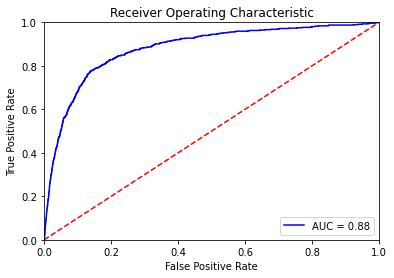

In [39]:
# построим ROC-кривую и посчитаем AUC
AUC_ROC(lr_model)

#### Внешний вид кривой и AUC не изменились

## 5. Balanced Random Forest Classifier

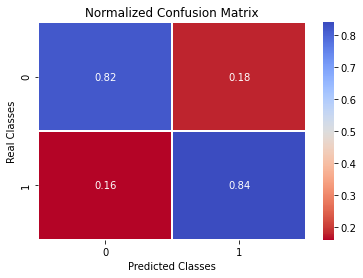

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     55412
           1       0.05      0.84      0.09       565

    accuracy                           0.82     55977
   macro avg       0.52      0.83      0.49     55977
weighted avg       0.99      0.82      0.89     55977



In [40]:
# строим модель Balanced Random Forest Classifier из библиотеки imblearn
model_brf = BalancedRandomForestClassifier(max_features=None, random_state=RANDOM_SEED)
model_brf.fit(x_train, y_train)
pred = model_brf.predict(x_test)
PlotConfusionMatrix(y_test, pred, y_test_0, y_test_1)

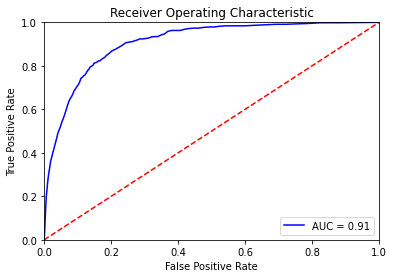

In [41]:
# построим ROC-кривую и посчитаем AUC
AUC_ROC(model_brf)

#### Значение AUC 0.88, confusion matrix выглядит лучше, чем в предыдущей модели. Это лучший результат, которого удалось достичь в ходе эксперимента

In [42]:
# посмотрим на feature importances
feat_importances = pd.Series(model_brf.feature_importances_, index=X.columns)
feat_importances.nlargest(40)

BID_CHANGE1    0.186372
VASK0          0.172131
VBID0          0.153375
ASK_CHANGE1    0.151807
SPREAD0        0.122964
BID_CH_02      0.109061
ASK_CH_0_2     0.104289
dtype: float64

### Общие выводы: для дальнейшего улучшения модели необходимо подробнее посмотреть на книгу заявок ("стакан"), т.к. не только объемы могут иметь значение, но и количество и время выставления заявок, например

## 6. Submission

In [43]:
predict_submission = model_brf.predict(test_data)

In [44]:
predict_submission

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [45]:
sample_prediction

,Y_PRED
0,0.0
1,0.5
2,1.0
3,0.0
4,0.5
...,...
93291,0.0
93292,0.5
93293,1.0
93294,0.0


In [46]:
sample_prediction['Y_PRED'] = predict_submission
sample_prediction.to_csv('submission.csv', index=False)
sample_prediction.head(10)

,Y_PRED
0,0
1,1
2,0
3,1
4,0
5,0
6,0
7,0
8,0
9,0
